Things we need to figure out:

-If a fund has no distribution for a date, do we set the distribution amount to 0 or do we drop the row?

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm

In [2]:
#Read in quarterly data from all mutual funds over all years in CRSP
fund_data = pd.read_csv('Mutual Fund Data.csv')
#Get only the Small Cap Value Funds
fund_data = fund_data[fund_data['lipper_class'] == 'SCVE']

c:\Users\amcre\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (3,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#Check for missing values in nav_latest
fund_data['nav_latest'].isnull().sum()

0

In [4]:
#find values of nav_latest that aren't float
fund_data['nav_latest'] = fund_data['nav_latest'].apply(lambda x: np.nan if type(x) != float else x)

In [5]:
dist_data = pd.read_csv('Mutual Fund Distribution Data.csv')

In [6]:
dist_data['caldt'] = dist_data['caldt'].apply(lambda x: dt.datetime.strptime(x, '%m/%d/%Y'))
dist_data['caldt'] = dist_data['caldt'].dt.date

In [7]:
fund_data['caldt'] = fund_data['caldt'].apply(lambda x: dt.datetime.strptime(x, '%m/%d/%Y'))
fund_data['caldt'] = fund_data['caldt'].dt.date

In [8]:
#from StackOverflow
def find_qrt(date):
    qrts = [dt.date(date.year - 1, 12, 31), dt.date(date.year, 3, 31),
            dt.date(date.year, 6, 30), dt.date(date.year, 9, 30),
            dt.date(date.year, 12, 31),
            ]
    ind = (date.month-1) // 3 + 1
    curr_qr, last_qr = qrts[ind],qrts[ind-1]
    return curr_qr if abs(curr_qr - date) <= abs(last_qr - date) else last_qr
dist_data['caldt'] = dist_data['caldt'].apply(lambda x: find_qrt(x))

In [9]:
dist_data.head(20)

,crsp_fundno,caldt,dis_type,dis_amt,reinvest_nav,spl_ratio
0,1,1997-03-31,D,0.0785,14.98,NaN
1,1,1997-03-31,D,0.0834,14.72,NaN
2,1,1997-03-31,D,0.0839,14.76,NaN
3,1,1997-06-30,D,0.0896,14.87,NaN
4,1,1997-06-30,D,0.0859,14.97,NaN
5,1,1997-06-30,D,0.0890,15.32,NaN
6,1,1997-09-30,D,0.0895,15.07,NaN
7,1,1997-09-30,D,0.0857,15.20,NaN
8,1,1997-09-30,D,0.0886,15.24,NaN
9,1,1997-12-31,D,0.0859,15.26,NaN


In [10]:
#Merge fund_data and dist_data on crsp_fundno and caldt with a left join
fund_data = pd.merge(fund_data, dist_data, how='left', on=['crsp_fundno','caldt'])
#If the return is null, then set the dis_amt value to 0 (there was no distribution on this date)
fund_data['dis_amt'] = fund_data['dis_amt'].apply(lambda x: 0 if np.isnan(x) else x)

In [11]:
fund_data

,summary_period2,crsp_fundno,caldt,nav_latest,tna_latest,cusip8,crsp_portno,fund_name,retail_fund,inst_fund,index_fund_flag,actual_12b1,mgmt_fee,exp_ratio,lipper_class,lipper_tax_cd,dis_type,dis_amt,reinvest_nav,spl_ratio
0,AQ,292,1999-12-31,7.27,15.1,NaN,NaN,CitiFunds Trust II: CitiFunds Small Cap Value ...,Y,N,NaN,NaN,NaN,NaN,SCVE,Taxable,NaN,0.0000,NaN,NaN
1,Q,292,2000-03-31,7.15,10.7,NaN,NaN,CitiFunds Trust II: CitiFunds Small Cap Value ...,Y,N,NaN,NaN,NaN,NaN,SCVE,Taxable,NaN,0.0000,NaN,NaN
2,Q,292,2000-06-30,7.19,8.8,17296150,NaN,CitiFunds Trust II: CitiFunds Small Cap Value ...,Y,N,NaN,NaN,NaN,NaN,SCVE,Taxable,NaN,0.0000,NaN,NaN
3,AQ,479,1999-12-31,10.30,33.5,23294140,NaN,The DLB Fund Group: DLB Enterprise III Fund,N,Y,NaN,NaN,NaN,NaN,SCVE,Taxable,CL,0.3093,9.95,NaN
4,AQ,479,1999-12-31,10.30,33.5,23294140,NaN,The DLB Fund Group: DLB Enterprise III Fund,N,Y,NaN,NaN,NaN,NaN,SCVE,Taxable,CS,0.2169,9.95,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34691,Q,99767,2022-06-30,9.02,0.1,02508F62,1053248.0,"American Century Capital Portfolios, Inc: Smal...",N,Y,NaN,NaN,NaN,NaN,SCVE,Taxable,DT,0.0564,8.96,NaN
34692,Q,99768,2022-06-30,9.01,0.1,02508F66,1053248.0,"American Century Capital Portfolios, Inc: Smal...",N,Y,NaN,NaN,NaN,NaN,SCVE,Taxable,DT,0.0397,8.96,NaN
34693,Q,99769,2022-06-30,9.01,0.1,02508F63,1053248.0,"American Century Capital Portfolios, Inc: Smal...",N,Y,NaN,NaN,NaN,NaN,SCVE,Taxable,DT,0.0425,8.96,NaN
34694,Q,99770,2022-06-30,9.01,0.1,02508F64,1053248.0,"American Century Capital Portfolios, Inc: Smal...",Y,N,NaN,NaN,NaN,NaN,SCVE,Taxable,DT,0.0265,8.96,NaN


In [16]:
#Get sum of nav_latest and dis_amt
fund_data['total_value'] = fund_data['nav_latest'] + fund_data['dis_amt']
#Compute returns by comparing NAV and dis_amt to NAV and dis_amt from the previous quarter
fund_data['return'] = fund_data.groupby(['fund_name'])['total_value'].pct_change()
#change the retail_fund column to a boolean
fund_data['retail_fund'] = fund_data['retail_fund'].apply(lambda x: 1 if x == 'Y' else 0).astype('category')
fund_data['retail_fund']

0        1
1        1
2        1
3        0
4        0
        ..
34691    0
34692    0
34693    0
34694    1
34695    0
Name: retail_fund, Length: 34696, dtype: category
Categories (2, int64): [0, 1]

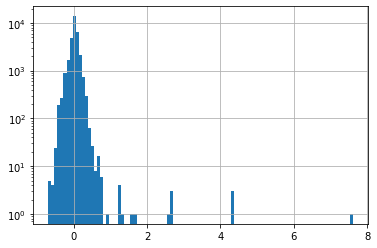

In [17]:
#plot histogram of returns with a log scale 
fund_data['return'].hist(bins=100, log=True)
#log transform the return column
fund_data['return'] = np.log(fund_data['return'] + 1)

<ipython-input-18-cd687bbeceed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund_data['tna_latest'] = np.log(fund_data['tna_latest'])


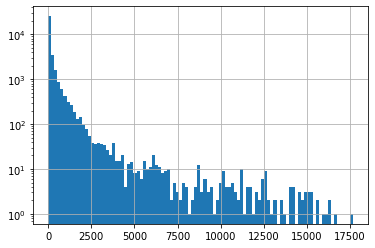

In [18]:
#drop rows where tna_latest is 0
fund_data = fund_data[fund_data['tna_latest'] != 0]
#plot histogram of tna_latest
fund_data['tna_latest'].hist(bins=100,log=True)
#log transform the tna_latest column
fund_data['tna_latest'] = np.log(fund_data['tna_latest'])

In [19]:
#get 5 bins of tna_latest
fund_data['tna_latest_bin'] = pd.qcut(fund_data['tna_latest'], 5, labels=False)
#drop rows with missing values in either return or tna_latest
fund_data = fund_data.dropna(subset=['return', 'tna_latest','mgmt_fee'])

<ipython-input-19-a6f07d5d937e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund_data['tna_latest_bin'] = pd.qcut(fund_data['tna_latest'], 5, labels=False)


In [20]:
#get dummies for tna_latest_bin
fund_data = pd.get_dummies(fund_data, columns=['tna_latest_bin'])

In [22]:
fund_data

,summary_period2,crsp_fundno,caldt,nav_latest,tna_latest,cusip8,crsp_portno,fund_name,retail_fund,inst_fund,...,dis_amt,reinvest_nav,spl_ratio,total_value,return,tna_latest_bin_0.0,tna_latest_bin_1.0,tna_latest_bin_2.0,tna_latest_bin_3.0,tna_latest_bin_4.0
12,AQ,671,1999-12-31,8.4800,4.446174,NaN,NaN,Evergreen Select Equity Trust: Evergreen Selec...,0,Y,...,0.008000,8.4800,NaN,8.488000,0.000471,0,0,0,1,0
13,Q,671,2000-03-31,8.3100,4.195697,NaN,NaN,Evergreen Select Equity Trust: Evergreen Selec...,0,Y,...,0.000000,NaN,NaN,8.310000,-0.021194,0,0,1,0,0
14,Q,671,2000-06-30,8.7300,4.198705,29990960,NaN,Evergreen Select Equity Trust: Evergreen Selec...,0,Y,...,0.014000,8.2800,NaN,8.744000,0.050908,0,0,1,0,0
15,Q,671,2000-06-30,8.7300,4.198705,29990960,NaN,Evergreen Select Equity Trust: Evergreen Selec...,0,Y,...,0.006000,8.7300,NaN,8.736000,-0.000915,0,0,1,0,0
31,AQ,2101,1999-12-31,9.8700,2.850707,NaN,NaN,The Winter Harbor Fund: REvest Value Fund,1,N,...,0.032500,9.6300,NaN,9.902500,-0.046159,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34629,Q,97753,2022-03-31,30.6835,5.190175,46436E53,1052028.0,iShares Trust: iShares US Small Cap Value Fact...,0,Y,...,0.050747,31.1766,NaN,30.734247,-0.047636,0,0,0,1,0
34632,Q,97787,2021-03-31,42.4800,-0.105361,92647Q23,1024537.0,Victory Portfolios: Victory Integrity Discover...,1,N,...,0.000000,NaN,NaN,42.480000,0.228868,1,0,0,0,0
34633,Q,97787,2021-06-30,45.5800,0.788457,92647Q23,1024537.0,Victory Portfolios: Victory Integrity Discover...,1,N,...,0.000000,NaN,NaN,45.580000,0.070436,1,0,0,0,0
34639,Q,98136,2021-06-30,15.3500,-2.302585,02507242,1051506.0,American Century ETF Trust: Avantis US Small C...,0,Y,...,0.000000,NaN,NaN,15.350000,0.054212,1,0,0,0,0


In [10]:
#find funds that have less than 20 observations and drop them
fund_data = fund_data.groupby('fund_name').filter(lambda x: len(x) > 20)
#create a dummy column for each fund name of type category
fund_data = pd.get_dummies(fund_data, columns=['fund_name'], drop_first=True)



In [24]:
#fit a regression model with return as the dependent variable and tna_latest, mgmt_fee, retail_fund, and the dummy columns as the independent variables
X = fund_data[['tna_latest', 'mgmt_fee']]
y = fund_data['return']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.933
Date:                Mon, 10 Oct 2022   Prob (F-statistic):             0.0532
Time:                        08:45:09   Log-Likelihood:                 18935.
No. Observations:               26558   AIC:                        -3.786e+04
Df Residuals:                   26555   BIC:                        -3.784e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.001      3.845      0.000       0.002       0.007
tna_latest     0.0007      0.000      2.392      0.017       0.000       0.001
mgmt_fee   -9.268e-06   1.81e-05     -0.511      0.609   -4.48e-05    2.63e-05
==============================================================================
Omnibus:                     5761.631   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           138175.018
Skew:                          -0.463   Prob(JB):                         0.00
Kurtosis:                      14.136   Cond. No.                         68.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
#for each tna_latest_bin, fit a regression predicting return
for i in range(5):
    X = fund_data[fund_data['tna_latest_bin_' + str(i)] == 1]
    X = X[['mgmt_fee', 'retail_fund']]
    y = X['return']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(model.summary())


KeyError: 'tna_latest_bin_0'

In [ ]:
fund_data

,summary_period2,crsp_fundno,caldt,nav_latest,tna_latest,cusip8,crsp_portno,retail_fund,inst_fund,index_fund_flag,...,fund_name_iShares Trust: iShares Morningstar Small-Cap Value ETF,fund_name_iShares Trust: iShares Russell 2000 Value ETF,fund_name_iShares Trust: iShares S&P Mid-Cap 400 Value ETF,fund_name_iShares Trust: iShares S&P Small-Cap 600 Value ETF,fund_name_iShares Trust: iShares S&P SmallCap 600 Value Index Fund,tna_latest_bin_0,tna_latest_bin_1,tna_latest_bin_2,tna_latest_bin_3,tna_latest_bin_4
35490,AQ,3537,12/31/2007,11.94,2.219203,00688P10,1004879.0,1,N,NaN,...,0,0,0,0,0,0,1,0,0,0
35491,Q,3537,03/31/2008,11.01,2.174752,00688P10,1004879.0,1,N,NaN,...,0,0,0,0,0,0,1,0,0,0
35492,Q,3537,06/30/2008,10.66,2.186051,00688P10,1004879.0,1,N,NaN,...,0,0,0,0,0,0,1,0,0,0
35493,Q,3537,09/30/2008,9.92,2.140066,00688P10,1004879.0,1,N,NaN,...,0,0,0,0,0,0,1,0,0,0
35494,AQ,3537,12/31/2008,7.52,1.871802,00688P10,1004879.0,1,N,NaN,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306515,AQ,87654,12/31/2020,11.49,3.987130,00770X39,1049049.0,0,Y,NaN,...,0,0,0,0,0,0,0,1,0,0
2306516,Q,87654,03/31/2021,13.89,4.328098,00770X39,1049049.0,0,Y,NaN,...,0,0,0,0,0,0,0,1,0,0
2306517,Q,87654,06/30/2021,14.15,4.497585,00770X39,1049049.0,0,Y,NaN,...,0,0,0,0,0,0,0,0,1,0
2306518,Q,87654,09/30/2021,14.09,4.632785,00770X39,1049049.0,0,Y,NaN,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
#get the correlation between tna_latest and return
fund_data['tna_latest'].corr(fund_data['return'])

0.03741093649756401

In [ ]:
data = pd.read_csv('Mutual Fund Data 2.csv')

c:\Users\amcre\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (3,12,15,32,37,39,40,46,47,49,50,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
data = data[data['lipper_class'] == 'SCVE']

In [ ]:
#find values of nav_latest that are string and convert to float
data['nav_latest'] = data['nav_latest'].apply(lambda x: float(x) if type(x) == str else x)
#find values of nav_latest that aren't float
data['nav_latest'] = data['nav_latest'].apply(lambda x: np.nan if type(x) != float else x)
data['return'] = (data['nav_latest']/data['nav_latest'].shift(1)) - 1

In [ ]:
data_quant = data.select_dtypes(include=['float64'])

In [ ]:
#find how many nan values are in each column
data_quant.isna().sum()
#drop yield, div_ytd, cap_gains_ytd, unrealized_app_dep, maturity, wbrger_obj_cd, policy 
data_quant = data_quant.drop(columns=['yield', 'div_ytd', 'cap_gains_ytd', 'unrealized_app_dep', 'maturity', 'wbrger_obj_cd', 'policy','merge_fundno'])

In [ ]:
data_quant = data_quant.dropna()
#log transform the return column
data_quant['return'] = np.log(data_quant['return'] + 1)
#drop nav_latest and nav_52w_h
data_quant = data_quant.drop(columns=['nav_latest', 'nav_52w_h'])


In [ ]:
#fit a regression predicting return with all the other columns from data_quant
X = data_quant.drop('return', axis=1)
y = data_quant['return']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.413
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           6.29e-17
Time:                        19:22:18   Log-Likelihood:                 2705.9
No. Observations:                7138   AIC:                            -5360.
Df Residuals:                    7112   BIC:                            -5181.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.1375      1.889      1.661      0.097      -0.566       6.841
tna_latest      2.165e-06   3.49e-06      0.621      0.535   -4.67e-06       9e-06
per_com           -0.0345      0.006     -5.617      0.000      -0.046      -0.022
per_pref          -0.0301      0.008     -3.896      0.000      -0.045      -0.015
per_conv          -0.0327      0.007     -4.801      0.000      -0.046      -0.019
per_corp          -0.0344      0.007     -4.799      0.000      -0.048      -0.020
per_muni          -0.0329      0.008     -3.896      0.000      -0.049      -0.016
per_govt          -0.0344      0.006     -5.565      0.000      -0.047      -0.022
per_oth           -0.0344      0.006     -5.611      0.000      -0.046      -0.022
per_cash          -0.0345      0.006     -5.631      0.000      -0.047      -0.023
per_bond          -0.0338      0.006     -5.234      0.000      -0.046      -0.021
per_abs           -0.1732      0.584     -0.296      0.767      -1.319       0.972
per_mbs            0.0169      0.204      0.083      0.934      -0.384       0.417
per_eq_oth        -0.0328      0.006     -5.053      0.000      -0.046      -0.020
per_fi_oth        -0.0357      0.008     -4.696      0.000      -0.051      -0.021
crsp_portno     2.029e-06   2.76e-07      7.345      0.000    1.49e-06    2.57e-06
crsp_cl_grp     2.121e-07   1.47e-07      1.447      0.148   -7.51e-08    4.99e-07
mgr_dt         -3.724e-08   5.37e-08     -0.693      0.488   -1.43e-07    6.81e-08
first_offer_dt -7.557e-08   4.49e-08     -1.683      0.092   -1.64e-07    1.25e-08
end_dt           2.21e-07   6.88e-08      3.214      0.001    8.62e-08    3.56e-07
actual_12b1       -0.0850      2.079     -0.041      0.967      -4.161       3.991
max_12b1           0.1918      1.938      0.099      0.921      -3.607       3.991
mgmt_fee          -0.0002      0.000     -0.568      0.570      -0.001       0.000
exp_ratio         -0.3596      0.732     -0.491      0.623      -1.794       1.075
turn_ratio         0.0013      0.001      1.215      0.224      -0.001       0.004
fiscal_yearend -2.179e-07    6.8e-08     -3.205      0.001   -3.51e-07   -8.46e-08
==============================================================================
Omnibus:                     2366.324   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           220331.691
Skew:                          -0.627   Prob(JB):                         0.00
Kurtosis:                      30.189   Cond. No.                     5.67e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+10. This might indicate that there are
strong multicollineari

In [ ]:
#get the coefficient for tna_latest
model.params['tna_latest']

2.164649548082119e-06

<AxesSubplot:xlabel='per_abs', ylabel='return'>

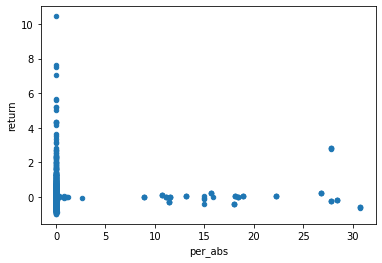

In [ ]:
#plot return against div_ytd
data.plot.scatter(x='per_abs', y='return')

In [ ]:
#find number of missing values for div_ytd
data['div_ytd'].isna().sum()

22422